# CNN using coronary heart disease data 

This work is aiming at the design and testing of a deep neural network architecture on Coronary heart disease using Tensorflow and Keras.

## Importing libraries

In [1]:
import numpy as np
import copy
from sklearn import preprocessing
import os
import pandas as pd
from matplotlib import pyplot as plt
from numpy.random import seed
np.random.seed(2095)

In [2]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [3]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

## Reading the data

In [4]:
# read input file
file = 'C:\\Users\\rohan\\OneDrive\\Documents\\CardiacPrediction_modified.xlsx'
ipData = pd.read_excel(file, sheet_name='CoroHeartDis')
print(ipData.columns) 

Index(['SEQN', 'Gender', 'Age', 'Annual-Family-Income',
       'Ratio-Family-Income-Poverty', 'X60-sec-pulse', 'Systolic', 'Diastolic',
       'Weight', 'Height', 'Body-Mass-Index', 'White-Blood-Cells',
       'Lymphocyte', 'Monocyte', 'Eosinophils', 'Basophils', 'Red-Blood-Cells',
       'Hemoglobin', 'Mean-Cell-Vol', 'Mean-Cell-Hgb-Conc.',
       'Mean-cell-Hemoglobin', 'Platelet-count', 'Mean-Platelet-Vol',
       'Segmented-Neutrophils', 'Hematocrit', 'Red-Cell-Distribution-Width',
       'Albumin', 'ALP', 'AST', 'ALT', 'Cholesterol', 'Creatinine', 'Glucose',
       'GGT', 'Iron', 'LDH', 'Phosphorus', 'Bilirubin', 'Protein', 'Uric.Acid',
       'Triglycerides', 'Total-Cholesterol', 'HDL', 'Glycohemoglobin',
       'Vigorous-work', 'Moderate-work', 'Health-Insurance', 'Diabetes',
       'Blood-Rel-Diabetes', 'Blood-Rel-Stroke', 'CoronaryHeartDisease'],
      dtype='object')


## Drop variables

In [5]:
# data drop
opLabel = np.array(ipData['CoronaryHeartDisease'])
ipData.drop(['SEQN','CoronaryHeartDisease','Annual-Family-Income','Height','Ratio-Family-Income-Poverty','X60-sec-pulse',
          'Health-Insurance','Lymphocyte','Monocyte','Eosinophils','Total-Cholesterol','Mean-Cell-Vol','Mean-Cell-Hgb-Conc.','Hematocrit','Segmented-Neutrophils'], axis = 1, inplace=True)

In [6]:
# dummy variable for categorical variables
ipData = pd.get_dummies(ipData,columns=["Gender","Diabetes","Blood-Rel-Diabetes","Blood-Rel-Stroke","Vigorous-work","Moderate-work"]) 

varb = np.array(ipData.columns)
ipData = np.array(ipData)
print(varb)

['Age' 'Systolic' 'Diastolic' 'Weight' 'Body-Mass-Index'
 'White-Blood-Cells' 'Basophils' 'Red-Blood-Cells' 'Hemoglobin'
 'Mean-cell-Hemoglobin' 'Platelet-count' 'Mean-Platelet-Vol'
 'Red-Cell-Distribution-Width' 'Albumin' 'ALP' 'AST' 'ALT' 'Cholesterol'
 'Creatinine' 'Glucose' 'GGT' 'Iron' 'LDH' 'Phosphorus' 'Bilirubin'
 'Protein' 'Uric.Acid' 'Triglycerides' 'HDL' 'Glycohemoglobin' 'Gender_1'
 'Gender_2' 'Diabetes_1' 'Diabetes_2' 'Diabetes_3' 'Blood-Rel-Diabetes_1'
 'Blood-Rel-Diabetes_2' 'Blood-Rel-Stroke_1' 'Blood-Rel-Stroke_2'
 'Vigorous-work_1' 'Vigorous-work_2' 'Vigorous-work_3' 'Moderate-work_1'
 'Moderate-work_2' 'Moderate-work_3']


In [7]:
print(ipData.shape)
print(varb)
print(len(opLabel[opLabel==0]))
print(len(opLabel[opLabel==1]))

(37079, 45)
['Age' 'Systolic' 'Diastolic' 'Weight' 'Body-Mass-Index'
 'White-Blood-Cells' 'Basophils' 'Red-Blood-Cells' 'Hemoglobin'
 'Mean-cell-Hemoglobin' 'Platelet-count' 'Mean-Platelet-Vol'
 'Red-Cell-Distribution-Width' 'Albumin' 'ALP' 'AST' 'ALT' 'Cholesterol'
 'Creatinine' 'Glucose' 'GGT' 'Iron' 'LDH' 'Phosphorus' 'Bilirubin'
 'Protein' 'Uric.Acid' 'Triglycerides' 'HDL' 'Glycohemoglobin' 'Gender_1'
 'Gender_2' 'Diabetes_1' 'Diabetes_2' 'Diabetes_3' 'Blood-Rel-Diabetes_1'
 'Blood-Rel-Diabetes_2' 'Blood-Rel-Stroke_1' 'Blood-Rel-Stroke_2'
 'Vigorous-work_1' 'Vigorous-work_2' 'Vigorous-work_3' 'Moderate-work_1'
 'Moderate-work_2' 'Moderate-work_3']
35571
1508


## Feature Nomination using LASSO

In [8]:
#Data condensation using LASSO penalty
from sklearn.linear_model import Lasso, LogisticRegression


featureVote = np.zeros(ipData.shape[1])
print(featureVote.shape)

iteR = 100

for num in range(iteR):
    label0_indx = np.where(opLabel==0)[0]   #no coronary heart disease
    label1_indx = np.where(opLabel==1)[0]   #coronary heart disease 
    numTrainData0 = 1300
    numTrainData1 = 1300
    np.random.shuffle(label0_indx)
    np.random.shuffle(label1_indx)
    
    label0_indx_train = label0_indx[0:numTrainData0-1]
    label1_indx_train = label1_indx[0:numTrainData1-1]
    label0_indx_test  = label0_indx[numTrainData0-1:]
    label1_indx_test  = label1_indx[numTrainData1-1:]
    
    testIndx  = np.append(label0_indx_test,label1_indx_test)
    trainIndx = np.append(label0_indx_train,label1_indx_train)    
    trainData  =  ipData[trainIndx]
    trainLabel =  opLabel[trainIndx]
    testData   =  ipData[testIndx]
    testLabel  =  opLabel[testIndx]    
    
    # data standardization
    scaler = preprocessing.StandardScaler().fit(trainData)
    trainData_scaled = scaler.transform(trainData)
    testData_scaled  = scaler.transform(testData)
    
    # Lasso from scikit
    regr = Lasso(random_state=0, alpha=0.006, tol=0.000001, max_iter=100000)
    regr.fit(trainData_scaled,trainLabel)
    cof = np.abs(regr.coef_)    
    colIndx = np.where(cof != 0)[0]
    for col in colIndx:
        featureVote[col]+=1


(45,)


In [9]:
print(featureVote)
print(featureVote[30:])

[100.  33.  82.  39.  14.  91.  50.  67.   9.  19. 100.  49. 100.  47.
  26.  24.   9. 100.  88.  14.  36.  33. 100.  24.  47.  25. 100.  99.
  96.  95. 100.  39.  86.  73.   5.  87.  47. 100.  52.  14.  13.  89.
   2.  99.  64.]
[100.  39.  86.  73.   5.  87.  47. 100.  52.  14.  13.  89.   2.  99.
  64.]


In [10]:
# feature nomination via Lasso (from feature 1 to 30)
# We keep the dummy variables

# Keep those variables which are nonzero at least 100//5=20 times
thresH = iteR//5
#thresH = 0
featureIndx = np.where(featureVote[0:30]>=thresH)[0]
featureIndx = np.append(featureIndx, np.arange(30,ipData.shape[1]))
print(varb[featureIndx])

['Age' 'Systolic' 'Diastolic' 'Weight' 'White-Blood-Cells' 'Basophils'
 'Red-Blood-Cells' 'Platelet-count' 'Mean-Platelet-Vol'
 'Red-Cell-Distribution-Width' 'Albumin' 'ALP' 'AST' 'Cholesterol'
 'Creatinine' 'GGT' 'Iron' 'LDH' 'Phosphorus' 'Bilirubin' 'Protein'
 'Uric.Acid' 'Triglycerides' 'HDL' 'Glycohemoglobin' 'Gender_1' 'Gender_2'
 'Diabetes_1' 'Diabetes_2' 'Diabetes_3' 'Blood-Rel-Diabetes_1'
 'Blood-Rel-Diabetes_2' 'Blood-Rel-Stroke_1' 'Blood-Rel-Stroke_2'
 'Vigorous-work_1' 'Vigorous-work_2' 'Vigorous-work_3' 'Moderate-work_1'
 'Moderate-work_2' 'Moderate-work_3']


In [11]:
# 5 variables have been removed
featureIndx.shape

(40,)

In [12]:
tInx = np.arange(ipData.shape[1])
rrInx = tInx[~np.isin(tInx,featureIndx)]
print(varb[rrInx])
# The variables removed from feature selection

['Body-Mass-Index' 'Hemoglobin' 'Mean-cell-Hemoglobin' 'ALT' 'Glucose']


# Combining Random Oversampling and Random Undersampling

In [13]:
# Forming the Train, Validation, and Test Splits
reduced_data = ipData[:,featureIndx]
indList=list(range(0,len(opLabel)))
np.random.shuffle(indList)

indTrain=indList[:int(.7*len(opLabel))]
indVal=indList[int(.7*len(opLabel)):int(.85*len(opLabel))]
indTest=indList[int(.85*len(opLabel)):]

x_train=reduced_data[indTrain]
x_val=reduced_data[indVal]
x_test=reduced_data[indTest]
print(len(x_train))
print(len(x_val))
print(len(x_test))
y_train=opLabel[indTrain]
y_val=opLabel[indVal]
y_test=opLabel[indTest]
print(Counter(y_train))

25955
5562
5562
Counter({0: 24911, 1: 1044})


In [14]:
# Apply Random Oversampling to the Minority Class
over=RandomOverSampler(sampling_strategy=0.1)
x_train, y_train=over.fit_resample(x_train,y_train)
print(Counter(y_train))

Counter({0: 24911, 1: 2491})


In [15]:
# Apply Random Undersampling to the Majority Class
under=RandomUnderSampler(sampling_strategy=0.5)
x_train,y_train=under.fit_resample(x_train,y_train)
print(Counter(y_train))

Counter({0: 4982, 1: 2491})


In [16]:
# Scales the data
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test  = scaler.transform(x_test)

## Interpreting the Confusion Matrix

In [17]:
def accuracy(confusion,show=1):
    precision=confusion[1,1]/(confusion[1,1]+confusion[0,1])
    recall=confusion[1,1]/(confusion[1,1]+confusion[1,0])
    specificity=confusion[0,0]/(confusion[0,0]+confusion[0,1])
    accuracy=(confusion[0,0]+confusion[1,1])/sum(sum(confusion))
    F1 = 2 * (precision * recall) / (precision + recall)
    if show:
        print("Precision:", precision)
        print("Recall:", recall)
        print("Specificity:", specificity)
        print("Accuracy:", accuracy)
        return f'F1 score: {F1}'
    return F1

# SVM: Validation

In [18]:
# Testing different hyperparameters
Clist=[0.01,0.05,0.1,1]
gammalist=[0.001,0.01,1/41,0.1]
svmVal=[]
for C in Clist:
    for gamma in gammalist:
        # Training SVM
        svcCAD = SVC(C=C, gamma=gamma, kernel='rbf', class_weight='balanced')
        svcCAD.fit(x_train,y_train)
        predlabel = svcCAD.predict(x_val)

        # Confusion matrix
        confMat = metrics.confusion_matrix(y_val, predlabel)
        print("Confusion Matrix:")
        print(confMat)

        # Calculating metrics
        svmVal.append([f'F1={accuracy(confMat,0)}',f'C={C}',f'gamma={gamma}'])
        print(accuracy(confMat), f'C={C}', f'gamma={gamma}')
        print("")

Confusion Matrix:
[[4460  867]
 [  97  138]]
Precision: 0.1373134328358209
Recall: 0.5872340425531914
Specificity: 0.8372442275201802
Accuracy: 0.8266810499820209
F1 score: 0.2225806451612903 C=0.01 gamma=0.001

Confusion Matrix:
[[3969 1358]
 [  48  187]]
Precision: 0.12103559870550162
Recall: 0.7957446808510639
Specificity: 0.7450722733245729
Accuracy: 0.7472132326501258
F1 score: 0.2101123595505618 C=0.01 gamma=0.01

Confusion Matrix:
[[3687 1640]
 [  42  193]]
Precision: 0.10529187124931806
Recall: 0.8212765957446808
Specificity: 0.6921344096114136
Accuracy: 0.6975907946781733
F1 score: 0.18665377176015474 C=0.01 gamma=0.024390243902439025

Confusion Matrix:
[[ 937 4390]
 [   2  233]]
Precision: 0.050400173047804454
Recall: 0.9914893617021276
Specificity: 0.1758963769476253
Accuracy: 0.21035598705501618
F1 score: 0.09592424866200082 C=0.01 gamma=0.1

Confusion Matrix:
[[4181 1146]
 [  57  178]]
Precision: 0.13444108761329304
Recall: 0.7574468085106383
Specificity: 0.784869532569926

In [19]:
svmVal.sort()
# The highest F1 Score
print(svmVal[-1])

['F1=0.2660098522167488', 'C=1', 'gamma=0.1']


# SVM: Testing

In [20]:
# Training SVM
svcCAD = SVC(C=1, gamma=0.1, kernel='rbf', class_weight='balanced')
svcCAD.fit(x_train,y_train)
predlabel = svcCAD.predict(x_test)

# Confusion Matrix
confMat = metrics.confusion_matrix(y_test,predlabel)
print(confMat)

# Results
accuracy(confMat)

[[4999  334]
 [ 158   71]]
Precision: 0.17530864197530865
Recall: 0.31004366812227074
Specificity: 0.9373710856928558
Accuracy: 0.9115426105717368


'F1 score: 0.22397476340694009'

# Logistic Regression: Validation

In [21]:
weightList=[None,'balanced',{0:0.67,1:0.33},{0:0.75, 1:0.25},{0:0.25, 1:0.75},{0:1,1:3.0}]
lrVal=[]

for classweight in weightList:
        # Training LR
        clf = LogisticRegression(solver = "lbfgs", class_weight=classweight, verbose=1, random_state = 2)
        model = clf.fit(x_train,y_train)
        predlabel = model.predict(x_val)
        
        # Confusion matrix
        confMat = metrics.confusion_matrix(y_val, predlabel)
        print("Confusion Matrix:")
        print(confMat)

        # Calculating metrics
        lrVal.append([f'F1={accuracy(confMat,0)}',f'class_weight={classweight}'])
        print(accuracy(confMat), f'class_weight={classweight}')
        print("")

Confusion Matrix:
[[4622  705]
 [  85  150]]
Precision: 0.17543859649122806
Recall: 0.6382978723404256
Specificity: 0.8676553407171016
Accuracy: 0.8579647608773823
F1 score: 0.2752293577981651 class_weight=None

Confusion Matrix:
[[4115 1212]
 [  46  189]]
Precision: 0.1349036402569593
Recall: 0.8042553191489362
Specificity: 0.7724798197859959
Accuracy: 0.7738223660553758
F1 score: 0.23105134474327627 class_weight=balanced

Confusion Matrix:
[[5015  312]
 [ 137   98]]
Precision: 0.23902439024390243
Recall: 0.41702127659574467
Specificity: 0.9414304486577811
Accuracy: 0.9192736425746134
F1 score: 0.30387596899224806 class_weight={0: 0.67, 1: 0.33}

Confusion Matrix:
[[5161  166]
 [ 169   66]]
Precision: 0.28448275862068967
Recall: 0.28085106382978725
Specificity: 0.9688379951192041
Accuracy: 0.939769866954333
F1 score: 0.2826552462526767 class_weight={0: 0.75, 1: 0.25}

Confusion Matrix:
[[3760 1567]
 [  30  205]]
Precision: 0.11568848758465011
Recall: 0.8723404255319149
Specificity: 0.

In [22]:
lrVal.sort()
# The highest F1 Score
print(lrVal[-1])

['F1=0.30387596899224806', 'class_weight={0: 0.67, 1: 0.33}']


# Logistic Regression: Testing 

In [23]:
# Training LR
clf = LogisticRegression(solver = "lbfgs", class_weight={0:0.67, 1:0.33}, verbose=1, random_state = 2)
model = clf.fit(x_train,y_train)
predlabel = model.predict(x_test)

# Confusion matrix
confMat = metrics.confusion_matrix(y_test, predlabel)
print("Confusion Matrix:")
print(confMat)
accuracy(confMat)

Confusion Matrix:
[[5001  332]
 [ 122  107]]
Precision: 0.2437357630979499
Recall: 0.4672489082969432
Specificity: 0.9377461091318208
Accuracy: 0.9183746853649766


'F1 score: 0.3203592814371258'

# KNN: Validation

In [24]:
klist=list(range(1,51))
averages=[]
k=1
for i in range(50):
    # Training KNN
    knn = KNeighborsClassifier(n_neighbors=k)  
    knn.fit(x_train, y_train)  # Use the training data
    predlabel = knn.predict(x_val)  # Predict on the validation set

    # Confusion matrix
    confMat = metrics.confusion_matrix(y_val, predlabel)
    print("Confusion Matrix:")
    print(confMat)
    print(f'K={k}')

    # Calculating averages
    averages.append(accuracy(confMat,0))
    print(accuracy(confMat))
    print("")
    k+=1

C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4749  578]
 [ 164   71]]
K=1
Precision: 0.10939907550077041
Recall: 0.3021276595744681
Specificity: 0.8914961516801202
Accuracy: 0.8665947500898957
F1 score: 0.1606334841628959



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4824  503]
 [ 173   62]]
K=2
Precision: 0.10973451327433628
Recall: 0.26382978723404255
Specificity: 0.905575370752769
Accuracy: 0.8784609852571018
F1 score: 0.155



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4434  893]
 [ 132  103]]
K=3
Precision: 0.10341365461847389
Recall: 0.43829787234042555
Specificity: 0.8323634315749953
Accuracy: 0.8157137720244516
F1 score: 0.16734362307067424



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4682  645]
 [ 148   87]]
K=4
Precision: 0.11885245901639344
Recall: 0.3702127659574468
Specificity: 0.8789187159752205
Accuracy: 0.8574253865516002
F1 score: 0.17993795243019647



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4411  916]
 [ 121  114]]
K=5
Precision: 0.11067961165048544
Recall: 0.4851063829787234
Specificity: 0.8280458043927164
Accuracy: 0.8135562747213233
F1 score: 0.18023715415019764



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4700  627]
 [ 137   98]]
K=6
Precision: 0.13517241379310344
Recall: 0.41702127659574467
Specificity: 0.8822977285526563
Accuracy: 0.8626393383674937
F1 score: 0.20416666666666664



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4496  831]
 [ 117  118]]
K=7
Precision: 0.12434141201264488
Recall: 0.502127659574468
Specificity: 0.8440022526750516
Accuracy: 0.8295577130528586
F1 score: 0.1993243243243243



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4702  625]
 [ 129  106]]
K=8
Precision: 0.14500683994528044
Recall: 0.451063829787234
Specificity: 0.8826731743945936
Accuracy: 0.8644372527867673
F1 score: 0.2194616977225673



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4536  791]
 [ 111  124]]
K=9
Precision: 0.1355191256830601
Recall: 0.5276595744680851
Specificity: 0.8515111695137977
Accuracy: 0.8378281193815175
F1 score: 0.21565217391304348



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4692  635]
 [ 127  108]]
K=10
Precision: 0.14535666218034993
Recall: 0.4595744680851064
Specificity: 0.8807959451849071
Accuracy: 0.8629989212513485
F1 score: 0.22085889570552145



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4565  762]
 [ 115  120]]
K=11
Precision: 0.1360544217687075
Recall: 0.5106382978723404
Specificity: 0.8569551342218885
Accuracy: 0.8423229054297016
F1 score: 0.21486123545210387



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4708  619]
 [ 127  108]]
K=12
Precision: 0.1485557083906465
Recall: 0.4595744680851064
Specificity: 0.8837995119204055
Accuracy: 0.8658755843221863
F1 score: 0.22453222453222457



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4573  754]
 [ 115  120]]
K=13
Precision: 0.13729977116704806
Recall: 0.5106382978723404
Specificity: 0.8584569175896377
Accuracy: 0.8437612369651205
F1 score: 0.21641118124436431



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4696  631]
 [ 131  104]]
K=14
Precision: 0.1414965986394558
Recall: 0.4425531914893617
Specificity: 0.8815468368687817
Accuracy: 0.8629989212513485
F1 score: 0.21443298969072164



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4599  728]
 [ 117  118]]
K=15
Precision: 0.13947990543735225
Recall: 0.502127659574468
Specificity: 0.8633377135348226
Accuracy: 0.8480762315713772
F1 score: 0.21831637372802962



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4710  617]
 [ 127  108]]
K=16
Precision: 0.1489655172413793
Recall: 0.4595744680851064
Specificity: 0.8841749577623428
Accuracy: 0.866235167206041
F1 score: 0.22499999999999998



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4614  713]
 [ 111  124]]
K=17
Precision: 0.14814814814814814
Recall: 0.5276595744680851
Specificity: 0.8661535573493524
Accuracy: 0.8518518518518519
F1 score: 0.23134328358208953



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4705  622]
 [ 121  114]]
K=18
Precision: 0.15489130434782608
Recall: 0.4851063829787234
Specificity: 0.8832363431574995
Accuracy: 0.8664149586479684
F1 score: 0.2348094747682801



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4629  698]
 [ 113  122]]
K=19
Precision: 0.14878048780487804
Recall: 0.5191489361702127
Specificity: 0.8689694011638821
Accuracy: 0.8541891405969075
F1 score: 0.23127962085308051



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4716  611]
 [ 118  117]]
K=20
Precision: 0.16071428571428573
Recall: 0.4978723404255319
Specificity: 0.8853012952881547
Accuracy: 0.8689320388349514
F1 score: 0.2429906542056075



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4647  680]
 [ 107  128]]
K=21
Precision: 0.15841584158415842
Recall: 0.5446808510638298
Specificity: 0.8723484137413178
Accuracy: 0.8585041352031644
F1 score: 0.2454458293384468



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4715  612]
 [ 116  119]]
K=22
Precision: 0.16279069767441862
Recall: 0.5063829787234042
Specificity: 0.885113572367186
Accuracy: 0.8691118302768788
F1 score: 0.24637681159420288



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4649  678]
 [ 111  124]]
K=23
Precision: 0.1546134663341646
Recall: 0.5276595744680851
Specificity: 0.8727238595832552
Accuracy: 0.8581445523193096
F1 score: 0.2391513982642237



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4717  610]
 [ 120  115]]
K=24
Precision: 0.15862068965517243
Recall: 0.48936170212765956
Specificity: 0.8854890182091233
Accuracy: 0.8687522473930241
F1 score: 0.23958333333333334



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4650  677]
 [ 115  120]]
K=25
Precision: 0.15056461731493098
Recall: 0.5106382978723404
Specificity: 0.8729115825042237
Accuracy: 0.8576051779935275
F1 score: 0.23255813953488372



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4705  622]
 [ 119  116]]
K=26
Precision: 0.15718157181571815
Recall: 0.49361702127659574
Specificity: 0.8832363431574995
Accuracy: 0.8667745415318231
F1 score: 0.2384378211716341



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4648  679]
 [ 113  122]]
K=27
Precision: 0.1523096129837703
Recall: 0.5191489361702127
Specificity: 0.8725361366622865
Accuracy: 0.8576051779935275
F1 score: 0.23552123552123552



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4707  620]
 [ 119  116]]
K=28
Precision: 0.15760869565217392
Recall: 0.49361702127659574
Specificity: 0.8836117889994368
Accuracy: 0.8671341244156778
F1 score: 0.23892893923789907



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4647  680]
 [ 112  123]]
K=29
Precision: 0.15317559153175592
Recall: 0.5234042553191489
Specificity: 0.8723484137413178
Accuracy: 0.8576051779935275
F1 score: 0.2369942196531792



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4706  621]
 [ 121  114]]
K=30
Precision: 0.15510204081632653
Recall: 0.4851063829787234
Specificity: 0.8834240660784681
Accuracy: 0.8665947500898957
F1 score: 0.23505154639175257



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4653  674]
 [ 113  122]]
K=31
Precision: 0.15326633165829145
Recall: 0.5191489361702127
Specificity: 0.8734747512671297
Accuracy: 0.8585041352031644
F1 score: 0.23666343355965078



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4719  608]
 [ 119  116]]
K=32
Precision: 0.16022099447513813
Recall: 0.49361702127659574
Specificity: 0.8858644640510607
Accuracy: 0.8692916217188061
F1 score: 0.24191866527632955



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4669  658]
 [ 114  121]]
K=33
Precision: 0.15532734274711169
Recall: 0.5148936170212766
Specificity: 0.8764783180026281
Accuracy: 0.8612010068320748
F1 score: 0.2386587771203156



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4721  606]
 [ 117  118]]
K=34
Precision: 0.16298342541436464
Recall: 0.502127659574468
Specificity: 0.886239909892998
Accuracy: 0.8700107874865156
F1 score: 0.24608967674661106



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4669  658]
 [ 113  122]]
K=35
Precision: 0.1564102564102564
Recall: 0.5191489361702127
Specificity: 0.8764783180026281
Accuracy: 0.8613807982740022
F1 score: 0.24039408866995074



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4712  615]
 [ 120  115]]
K=36
Precision: 0.15753424657534246
Recall: 0.48936170212765956
Specificity: 0.8845504036042801
Accuracy: 0.8678532901833873
F1 score: 0.23834196891191708



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4666  661]
 [ 115  120]]
K=37
Precision: 0.15364916773367476
Recall: 0.5106382978723404
Specificity: 0.8759151492397221
Accuracy: 0.8604818410643653
F1 score: 0.23622047244094488



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4718  609]
 [ 124  111]]
K=38
Precision: 0.15416666666666667
Recall: 0.4723404255319149
Specificity: 0.885676741130092
Accuracy: 0.868212873067242
F1 score: 0.23246073298429323



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4684  643]
 [ 117  118]]
K=39
Precision: 0.15505913272010513
Recall: 0.502127659574468
Specificity: 0.8792941618171579
Accuracy: 0.8633585041352032
F1 score: 0.23694779116465864



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4724  603]
 [ 124  111]]
K=40
Precision: 0.15546218487394958
Recall: 0.4723404255319149
Specificity: 0.8868030786559039
Accuracy: 0.8692916217188061
F1 score: 0.2339304531085353



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4673  654]
 [ 115  120]]
K=41
Precision: 0.15503875968992248
Recall: 0.5106382978723404
Specificity: 0.8772292096865028
Accuracy: 0.8617403811578569
F1 score: 0.23785926660059467



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4719  608]
 [ 121  114]]
K=42
Precision: 0.15789473684210525
Recall: 0.4851063829787234
Specificity: 0.8858644640510607
Accuracy: 0.8689320388349514
F1 score: 0.23824451410658304



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4678  649]
 [ 117  118]]
K=43
Precision: 0.15384615384615385
Recall: 0.502127659574468
Specificity: 0.878167824291346
Accuracy: 0.862279755483639
F1 score: 0.23552894211576847



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4717  610]
 [ 119  116]]
K=44
Precision: 0.15977961432506887
Recall: 0.49361702127659574
Specificity: 0.8854890182091233
Accuracy: 0.8689320388349514
F1 score: 0.24141519250780435



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4677  650]
 [ 117  118]]
K=45
Precision: 0.15364583333333334
Recall: 0.502127659574468
Specificity: 0.8779801013703773
Accuracy: 0.8620999640417116
F1 score: 0.2352941176470588



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4719  608]
 [ 121  114]]
K=46
Precision: 0.15789473684210525
Recall: 0.4851063829787234
Specificity: 0.8858644640510607
Accuracy: 0.8689320388349514
F1 score: 0.23824451410658304



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4678  649]
 [ 116  119]]
K=47
Precision: 0.15494791666666666
Recall: 0.5063829787234042
Specificity: 0.878167824291346
Accuracy: 0.8624595469255664
F1 score: 0.23728813559322035



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4710  617]
 [ 125  110]]
K=48
Precision: 0.15130674002751032
Recall: 0.46808510638297873
Specificity: 0.8841749577623428
Accuracy: 0.8665947500898957
F1 score: 0.22869022869022873



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4681  646]
 [ 118  117]]
K=49
Precision: 0.15334207077326342
Recall: 0.4978723404255319
Specificity: 0.878730993054252
Accuracy: 0.8626393383674937
F1 score: 0.2344689378757515

Confusion Matrix:
[[4724  603]
 [ 123  112]]
K=50
Precision: 0.15664335664335666
Recall: 0.4765957446808511
Specificity: 0.8868030786559039
Accuracy: 0.8694714131607335
F1 score: 0.23578947368421052



C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


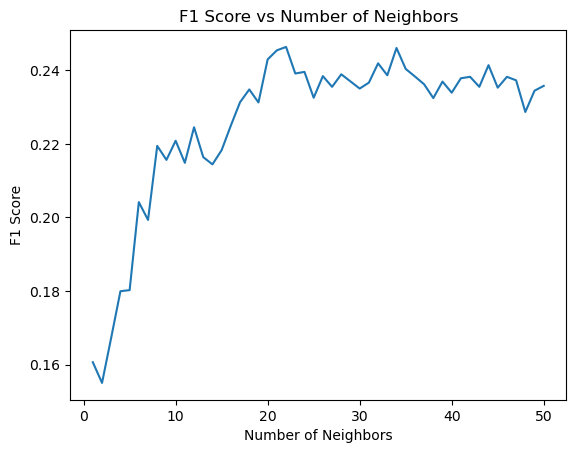

22


In [25]:
# Plot of the optimal number of neighbors
plt.plot(klist, averages)
plt.xlabel("Number of Neighbors")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Number of Neighbors")
plt.show()
# The optimal number of neighbors
print(averages.index(max(averages))+1)

# KNN: Testing

In [26]:
# Training KNN
knn = KNeighborsClassifier(n_neighbors=22)  
knn.fit(x_train, y_train)
predlabel = knn.predict(x_test)

# Confusion matrix
confMat = metrics.confusion_matrix(y_test, predlabel)
print("Confusion Matrix:")
print(confMat)

# Calculating accuracy
print(accuracy(confMat))

Confusion Matrix:
[[4688  645]
 [ 106  123]]
Precision: 0.16015625
Recall: 0.537117903930131
Specificity: 0.8790549409338083
Accuracy: 0.8649766271125494
F1 score: 0.24674022066198595


C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


# Vote: Validation

In [27]:
# We use the tuned hyperparameters from above
svm = SVC(C=1, gamma=0.1, kernel='rbf', class_weight='balanced')
lr = LogisticRegression(solver = "lbfgs", class_weight={0:0.67, 1:0.33}, verbose=1, random_state = 2)
knn = KNeighborsClassifier(n_neighbors=22)
voting_clf = VotingClassifier(estimators=[('knn', knn), ('svm', svm), ('lr', lr)], voting='hard')
voting_clf.fit(x_train, y_train)  # Use the training data
predlabel = voting_clf.predict(x_val)  # Predict on the validation set

# Confusion matrix
confMat = metrics.confusion_matrix(y_val, predlabel)
print("Confusion Matrix:")
print(confMat)

# Calculating metrics
accuracy(confMat)

C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4986  341]
 [ 133  102]]
Precision: 0.23024830699774265
Recall: 0.4340425531914894
Specificity: 0.9359864839496903
Accuracy: 0.9147788565264293


'F1 score: 0.30088495575221236'

# Vote: Testing

In [28]:
svm = SVC(C=1, gamma=0.1, kernel='rbf', class_weight='balanced')
lr = LogisticRegression(solver = "lbfgs", class_weight={0:0.67, 1:0.33}, verbose=1, random_state = 2)
knn = KNeighborsClassifier(n_neighbors=22)
voting_clf = VotingClassifier(estimators=[('knn', knn), ('svm', svm), ('lr', lr)], voting='hard')
voting_clf.fit(x_train, y_train)  # Use the training data
predlabel = voting_clf.predict(x_test)  # Predict on the testing set

# Confusion matrix
confMat = metrics.confusion_matrix(y_test, predlabel)
print("Confusion Matrix:")
print(confMat)

# Calculating metrics
accuracy(confMat)

C:\Users\rohan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix:
[[4956  377]
 [ 125  104]]
Precision: 0.21621621621621623
Recall: 0.45414847161572053
Specificity: 0.9293080817551097
Accuracy: 0.9097446961524631


'F1 score: 0.2929577464788733'